In [1]:
import pandas as pd
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow.keras.layers import LSTM, Dense

2022-04-19 09:36:37.483662: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
meta = []

for i in range(1,26):
    meta.append(['arac', 'x%d' % i])
    
for i in range(26,51):
    meta.append(['arkaplan', 'x%d' % i])
    
for i in range(51,76):
    meta.append(['hayvan', 'x%d' % i])
    
for i in range(76,101):
    meta.append(['insan', 'x%d' % i])
    
label_map = ['Arac', 'Arkaplan', 'Hayvan', 'Insan']

In [3]:
import numpy as np

NUM_FEATURES = 128

def features_extractor(file_name, NUM_FEATURES):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=NUM_FEATURES)
    
    mfccs_features = mfccs_features.T
    #mfccs_features = mfccs_features.reshape((1, mfccs_features.shape[0], mfccs_features.shape[1]))
    
    #return mfccs_features[:700]
    return mfccs_features, audio


extracted_features=[]
original_features=[]

for c, filename in meta:
    
    file_name = f"./downsample/{filename}.wav"

    data, original_data =features_extractor(file_name, NUM_FEATURES)
    extracted_features.append([data, c])
    original_features.append(original_data.tolist())

In [4]:
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature', 'class'])
extracted_features_df.head(10)

,feature,class
0,"[[-252.69997, 157.74219, -14.976885, 43.705845...",arac
1,"[[-241.23976, 171.48753, 7.499474, 39.061058, ...",arac
2,"[[-230.91533, 106.09454, 17.360027, 36.846504,...",arac
3,"[[-150.06833, 241.7922, -36.47016, 7.4844136, ...",arac
4,"[[-222.76315, 202.01587, -35.510597, 26.660997...",arac
5,"[[-134.91563, 159.38596, 20.196404, 28.565296,...",arac
6,"[[-200.31755, 168.40308, -40.759666, 0.6482765...",arac
7,"[[-198.80725, 176.5911, -1.5869819, 45.292442,...",arac
8,"[[-172.58052, 225.5242, -63.19178, 44.00025, 4...",arac
9,"[[-185.34874, 228.64188, -88.755264, 19.502235...",arac


In [5]:
import tensorflow as tf

padded_inputs = tf.keras.preprocessing.sequence.pad_sequences(
    extracted_features_df['feature'].tolist(), padding="post")

In [6]:
original_features = np.array(original_features)
original_features.shape

(100, 88200)

In [7]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

y=np.array(extracted_features_df['class'].tolist())

labelencoder=LabelEncoder()
yold = y.copy()
y=to_categorical(labelencoder.fit_transform(y))

In [8]:
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
    
from sklearn.metrics import *
bestacc = 0



skf = StratifiedKFold(n_splits=5)

from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.optimizers import *

ypreds = np.zeros((len(padded_inputs),4))

for tr, val in skf.split(padded_inputs, yold):

    tf.random.set_seed(3)
    X_train = padded_inputs[tr]
    X_val = padded_inputs[val]
    Y_train = np.array([y[ind].tolist() for ind in tr]).astype(np.float32)
    Y_val = np.array([y[ind].tolist() for ind in val]).astype(np.float32)

    inp = Input(shape=(None,NUM_FEATURES))
    x = LSTM(5,return_sequences= True )(inp)
    x = LSTM(5, )(x)
    x = Dense(16,activation='relu')(x)
    x = Dense(16,activation='relu')(x)
    out = Dense(4,activation='softmax')(x)

    model = Model(inputs=inp, outputs=out)

    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, verbose = 0)

    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    history = model.fit(X_train, Y_train, batch_size=1, epochs=500, validation_data=(X_val, Y_val), verbose =0, callbacks = [es])

    ypreds[val] = model.predict(X_val)


curacc = accuracy_score(np.argsort(y,axis=1)[:,-1], np.argsort(ypreds,axis=1)[:,-1])
print(['Finished, final Accuracy:', curacc])

2022-04-19 09:36:43.592810: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-04-19 09:36:43.661802: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-19 09:36:43.662032: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 1660 Ti computeCapability: 7.5
coreClock: 1.77GHz coreCount: 24 deviceMemorySize: 5.80GiB deviceMemoryBandwidth: 268.26GiB/s
2022-04-19 09:36:43.662059: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-04-19 09:36:43.663804: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-04-19 09:36:43.663900: I tensorflow/stream_executor/platform

['Finished, final Accuracy:', 0.86]


In [9]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig = plt.figure(figsize=(10,7))
    

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

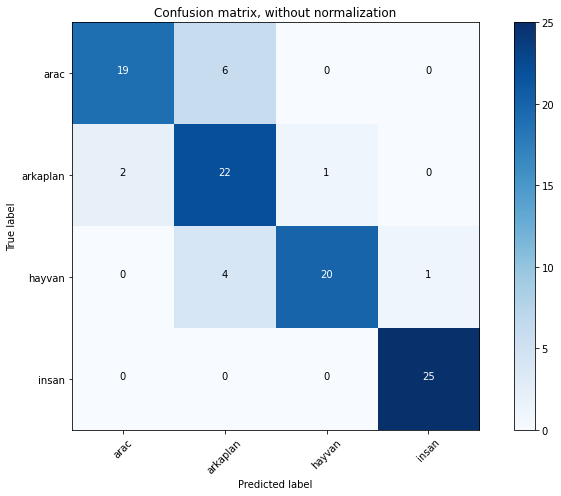

In [10]:
from sklearn.metrics import confusion_matrix

class_names = dict(zip(range(len(labelencoder.classes_)),labelencoder.classes_))

y_true = np.argsort(y,axis=1)[:,-1]
y_pred = np.argsort(ypreds,axis=1)[:,-1]

y_true
y_pred

cnf_matrix = confusion_matrix([class_names[x] for x in y_true],
                 [class_names[x] for x in y_pred],
                 labels=labelencoder.classes_)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_,
                      title='Confusion matrix, without normalization')